In [ ]:
## pip install xgboost --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


In [2]:
# Load data
data = pd.read_csv('crop_recommendation.csv')

In [ ]:
data['label'].value_counts()

In [4]:
# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Calculate the correlation matrix
correlation_matrix = X.corr().abs()

# Get the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Find columns (features) to drop (those with a correlation greater than 0.85)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop correlated columns
X = X.drop(X[to_drop], axis=1)

# Split the data into train (70%) and temp (30%)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.30, random_state=0)

# Split the temp data into test (2/3 of 20%) and validation (1/3 of 20%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=0)

# The resulting splits should be roughly 70-20-10
print("Training set size:", len(X_train_temp))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 30800
Testing set size: 8800
Validation set size: 4400


Cross-validated accuracy scores for each fold: [0.94875    0.94818182 0.94886364 0.94681818 0.94886364]
Mean CV Accuracy: 0.9482954545454545
Standard Deviation of CV Accuracy: 0.0007807074562417197
Random Forest Test accuracy: 0.9359090909090909
Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       1.00      1.00      1.00       402
   blackgram       0.74      0.99      0.85       394
    chickpea       1.00      1.00      1.00       423
     coconut       1.00      0.97      0.98       381
      coffee       1.00      1.00      1.00       411
      cotton       1.00      1.00      1.00       387
      grapes       1.00      1.00      1.00       375
        jute       1.00      0.18      0.30       406
 kidneybeans       1.00      1.00      1.00       389
      lentil       0.90      1.00      0.95       370
       maize       0.99      1.00      0.99       408
       mango  

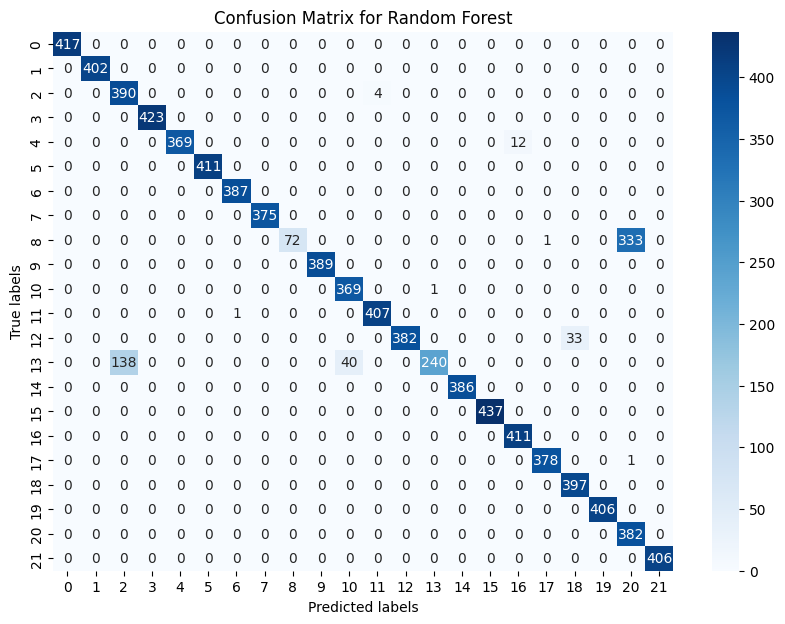

In [12]:
# Random Forest
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=6, max_features=5, random_state=0)
clf_rf.fit(X_train_temp, y_train_temp)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_rf, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_rf = clf_rf.predict(X_test)
accuracy_score_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Test accuracy:", accuracy_score_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_rf = label_binarize(y_pred_rf, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

# Plot using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# # Compute macro-average ROC curve and ROC area for multi-class task
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_rf[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# print("Random Forest Macro-average of ROC curve:", roc_auc["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Random Forest')
# plt.legend(loc="lower right")
# plt.show()



Cross-validated accuracy scores for each fold: [0.89443182 0.89477273 0.89420455 0.89465909 0.89465909]
Mean CV Accuracy: 0.8945454545454545
Standard Deviation of CV Accuracy: 0.00020327890704544915
Naive Bayes Test accuracy: 0.8861363636363636
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       0.89      1.00      0.94       402
   blackgram       0.67      0.92      0.77       394
    chickpea       1.00      1.00      1.00       423
     coconut       0.96      0.89      0.92       381
      coffee       1.00      0.86      0.92       411
      cotton       0.89      1.00      0.94       387
      grapes       1.00      1.00      1.00       375
        jute       0.59      1.00      0.74       406
 kidneybeans       0.85      0.90      0.87       389
      lentil       0.74      1.00      0.85       370
       maize       0.96      0.85      0.91       408
       mango       0.99      1.00      1.00       41

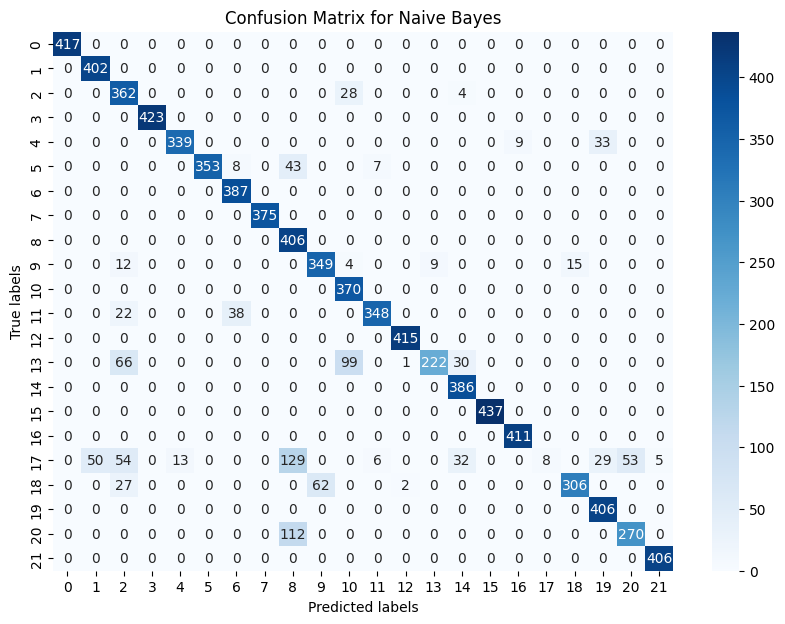

In [13]:
# Set var_smoothing parameter for regularization; you can adjust the value as needed
# Naive Bayes with regularization
var_smoothing_value = 1e-0
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_nb, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the model with the training data and predict for the test set
clf_nb.fit(X_train_temp, y_train_temp)
y_pred_nb = clf_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

# Print the Naive Bayes Classification Report
print("Naive Bayes Test accuracy:", accuracy_score_nb)
print(classification_report(y_test, y_pred_nb))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_nb = label_binarize(y_pred_nb, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Plot using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

# # For the ROC Curve for multi-class
# y_bin_test_nb = label_binarize(y_test, classes=data['label'].unique())
# y_bin_pred_nb = label_binarize(y_pred_nb, classes=data['label'].unique())
# n_classes_nb = y_bin_test_nb.shape[1]

# fpr_nb = dict()
# tpr_nb = dict()
# roc_auc_nb = dict()

# for i in range(n_classes_nb):
#     fpr_nb[i], tpr_nb[i], _ = roc_curve(y_bin_test_nb[:, i], y_bin_pred_nb[:, i])
#     roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])

# all_fpr_nb = np.unique(np.concatenate([fpr_nb[i] for i in range(n_classes_nb)]))
# mean_tpr_nb = np.zeros_like(all_fpr_nb)
# for i in range(n_classes_nb):
#     mean_tpr_nb += np.interp(all_fpr_nb, fpr_nb[i], tpr_nb[i])
# mean_tpr_nb /= n_classes_nb

# fpr_nb["macro"] = all_fpr_nb
# tpr_nb["macro"] = mean_tpr_nb
# roc_auc_nb["macro"] = auc(fpr_nb["macro"], tpr_nb["macro"])

# print("Naive Bayes Macro-average of ROC curve on Test Set:", roc_auc_nb["macro"])

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr_nb["macro"], tpr_nb["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc_nb["macro"]),
#          color='navy', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for Naive Bayes')
# plt.legend(loc="lower right")
# plt.show()

Cross-validated accuracy scores for each fold (SVM): [0.96727273 0.96784091 0.96727273 0.9675     0.96670455]
Mean CV Accuracy (SVM): 0.9673181818181819
Standard Deviation of CV Accuracy (SVM): 0.0003706706006886634
SVM Test accuracy: 0.9640909090909091
SVM Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       1.00      1.00      1.00       402
   blackgram       0.89      0.95      0.92       394
    chickpea       1.00      1.00      1.00       423
     coconut       0.99      1.00      0.99       381
      coffee       1.00      1.00      1.00       411
      cotton       0.99      1.00      0.99       387
      grapes       1.00      1.00      1.00       375
        jute       0.80      1.00      0.89       406
 kidneybeans       0.97      1.00      0.98       389
      lentil       0.87      0.94      0.90       370
       maize       1.00      0.99      1.00       408
       mango    

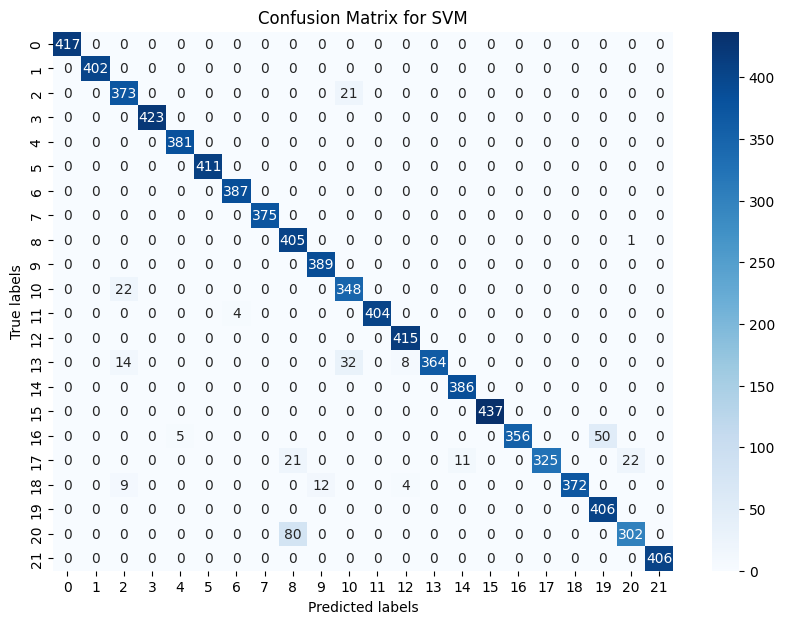

In [5]:
# Use pipeline to ensure that the data is scaled before applying SVM
clf_svm = make_pipeline(
    StandardScaler(), 
    SVC(gamma= 'auto', C=0.01, random_state=0) # Updated kernel and gamma
)

# Using the pipeline to fit and predict ensures that scaling is applied in each step of CV and prediction.
clf_svm.fit(X_train_temp, y_train_temp)

# Perform 5-fold cross-validation
cv_scores_svm = cross_val_score(clf_svm, X, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy for SVM
print("Cross-validated accuracy scores for each fold (SVM):", cv_scores_svm)
print("Mean CV Accuracy (SVM):", cv_scores_svm.mean())
print("Standard Deviation of CV Accuracy (SVM):", cv_scores_svm.std())

y_pred_svm = clf_svm.predict(X_test)
accuracy_score_svm = accuracy_score(y_test, y_pred_svm)

print("SVM Test accuracy:", accuracy_score_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Binarize the labels for SVM
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_svm = label_binarize(y_pred_svm, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Plot using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM')
plt.show()

# # Compute macro-average ROC curve and ROC area for multi-class task for SVM
# fpr_svm = dict()
# tpr_svm = dict()
# roc_auc_svm = dict()

# for i in range(n_classes):
#     fpr_svm[i], tpr_svm[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_svm[:, i])
#     roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# all_fpr_svm = np.unique(np.concatenate([fpr_svm[i] for i in range(n_classes)]))
# mean_tpr_svm = np.zeros_like(all_fpr_svm)
# for i in range(n_classes):
#     mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[i], tpr_svm[i])
# mean_tpr_svm /= n_classes

# fpr_svm["macro"] = all_fpr_svm
# tpr_svm["macro"] = mean_tpr_svm
# roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# print("SVM Macro-average of ROC curve:", roc_auc_svm["macro"])

# # Plot the ROC curve for SVM
# plt.figure()
# plt.plot(fpr_svm["macro"], tpr_svm["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc_svm["macro"]),
#          color='green', linestyle=':', linewidth=4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve for SVM')
# plt.legend(loc="lower right")
# plt.show()

Cross-validated accuracy scores for each fold: [0.87295455 0.87579545 0.87238636 0.87375    0.87625   ]
Mean CV Accuracy: 0.8742272727272727
Standard Deviation of CV Accuracy: 0.0015353950685504084
Logistic Regression Test accuracy: 0.87375
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       417
      banana       0.96      1.00      0.98       402
   blackgram       0.75      0.89      0.82       394
    chickpea       0.99      1.00      1.00       423
     coconut       0.90      1.00      0.95       381
      coffee       0.91      1.00      0.95       411
      cotton       0.88      0.98      0.93       387
      grapes       1.00      1.00      1.00       375
        jute       0.96      0.43      0.60       406
 kidneybeans       0.87      0.99      0.93       389
      lentil       0.83      0.91      0.87       370
       maize       1.00      0.81      0.89       408
       mango 

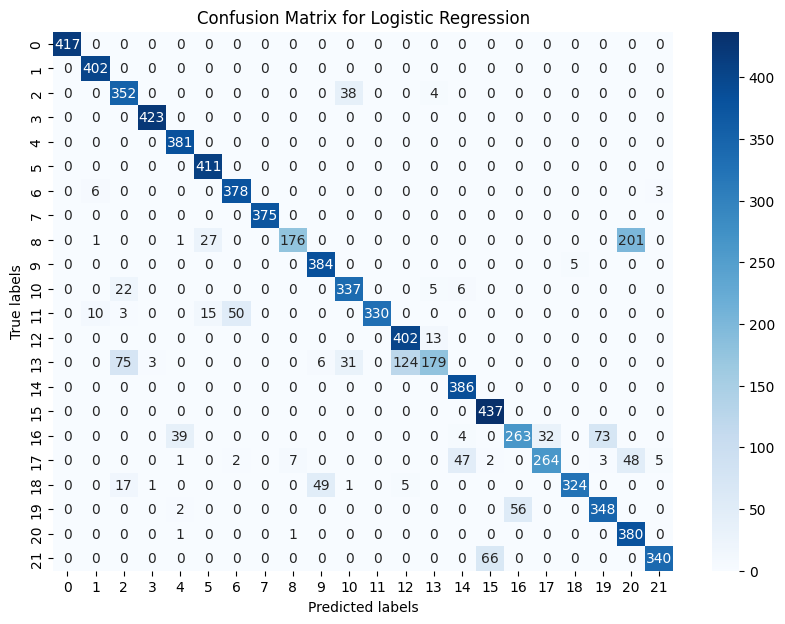

In [6]:
# Scaling the features
scaler = StandardScaler()
X_train_temp_scaled = scaler.fit_transform(X_train_temp)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)  
clf_lr.fit(X_train_temp_scaled, y_train_temp)

# Remember to scale the entire dataset for cross-validation
X_scaled = scaler.transform(X)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_lr, X_scaled, y, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Test accuracy:", accuracy_score_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=data['label'].unique())
y_bin_pred_lr = label_binarize(y_pred_lr, classes=data['label'].unique())
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Plot using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Cross-validated accuracy scores for each fold: [0.9599026  0.96428571 0.96801948 0.9663961  0.95584416]
Mean CV Accuracy: 0.9628896103896103
Standard Deviation of CV Accuracy: 0.00445243409127595
XGBoost Test accuracy: 0.96375
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       402
           2       0.85      0.99      0.92       394
           3       1.00      1.00      1.00       423
           4       0.84      0.99      0.91       381
           5       1.00      1.00      1.00       411
           6       1.00      1.00      1.00       387
           7       1.00      1.00      1.00       375
           8       0.83      0.99      0.90       406
           9       0.99      1.00      0.99       389
          10       0.92      1.00      0.96       370
          11       0.99      0.99      0.99       408
          12       0.96      1.00      

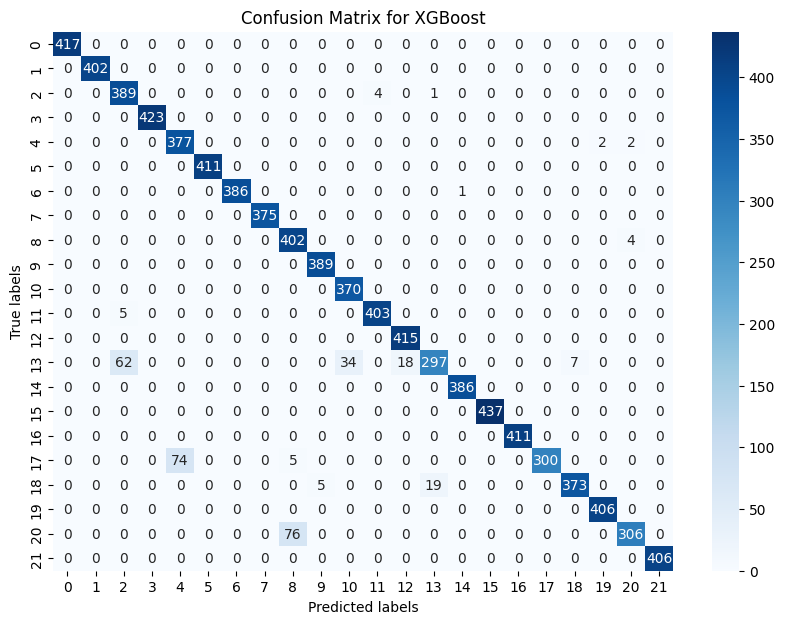

In [10]:


# Convert string labels to integers
le = LabelEncoder()
y_train_temp_encoded = le.fit_transform(y_train_temp)
y_test_encoded = le.transform(y_test)

# Define the XGBoost classifier with modifications
clf_xgb = xgb.XGBClassifier(
    n_estimators=5,         # Number of boosting rounds.
    max_depth=3,              # Maximum tree depth for base learners.
    min_child_weight=5,       # Minimum sum of instance weight (hessian) needed in a child.
    gamma=0.01,               # Minimum loss reduction required to make a further partition.
    learning_rate=0.03,       # Boosting learning rate (xgb's "eta")
    objective='multi:softmax',# Multiclass classification using the softmax objective
    random_state=0            # Seed for reproducibility
)

# Fit the model
clf_xgb.fit(X_train_temp, y_train_temp_encoded)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf_xgb, X_train_temp, y_train_temp_encoded, cv=5, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Prediction on test set
y_pred_xgb_encoded = clf_xgb.predict(X_test)
accuracy_score_xgb = accuracy_score(y_test_encoded, y_pred_xgb_encoded)

print("XGBoost Test accuracy:", accuracy_score_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb_encoded))

# Binarize the labels for confusion matrix
y_bin_test = label_binarize(y_test_encoded, classes=list(range(len(data['label'].unique()))))
y_bin_pred_xgb = label_binarize(y_pred_xgb_encoded, classes=list(range(len(data['label'].unique()))))
n_classes = y_bin_test.shape[1]

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test_encoded, y_pred_xgb_encoded)

# Plot using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


In [14]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
print("Naive Bayes Accuracy:", accuracy_score_nb)
print("SVM Accuracy:", accuracy_score_svm)
print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
print("XGBoost Accuracy:", accuracy_score_xgb)


Random Forest Accuracy: 0.9359090909090909
Naive Bayes Accuracy: 0.8861363636363636
SVM Accuracy: 0.9640909090909091
Logistic Regression Accuracy (Scaled Data): 0.87375
XGBoost Accuracy: 0.96375


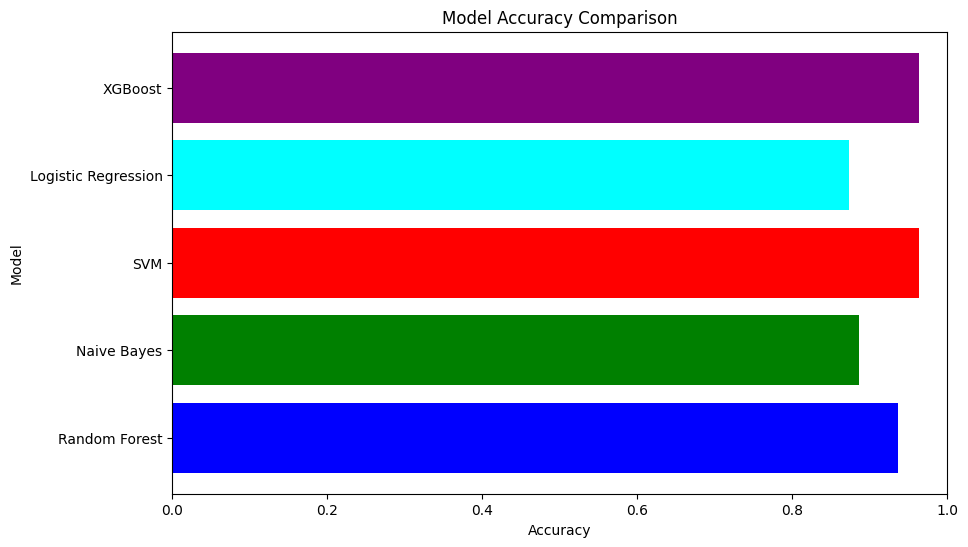

In [15]:


# Assuming you have stored the accuracies in the following manner:
model_names = ['Random Forest', 'Naive Bayes', 'SVM', 'Logistic Regression', 'XGBoost']
accuracies = [accuracy_score_rf, accuracy_score_nb, accuracy_score_svm, accuracy_score_lr, accuracy_score_xgb]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color=['blue', 'green', 'red', 'cyan', 'purple'])
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)  # Assuming accuracy is a fraction. If it's in %, change to (0,100)
plt.show()